# ETL PROJECT

### Import Dependencies

In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import requests
from pprint import pprint
import json
import pymongo
from pymongo import MongoClient

url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=GLD&apikey=FCKEHHSIL3S8ZR1U"

#api_key = "FCKEHHSIL3S8ZR1U"

In [2]:
response = requests.get(url)
payload = response.json()
payload

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
  '2. Symbol': 'GLD',
  '3. Last Refreshed': '2019-08-09',
  '4. Output Size': 'Compact',
  '5. Time Zone': 'US/Eastern'},
 'Time Series (Daily)': {'2019-08-09': {'1. open': '141.2800',
   '2. high': '142.0300',
   '3. low': '140.9600',
   '4. close': '141.2600',
   '5. volume': '9444600'},
  '2019-08-08': {'1. open': '140.9000',
   '2. high': '142.3700',
   '3. low': '140.7100',
   '4. close': '141.7300',
   '5. volume': '13108600'},
  '2019-08-07': {'1. open': '141.2800',
   '2. high': '142.4700',
   '3. low': '140.8800',
   '4. close': '141.0200',
   '5. volume': '26671100'},
  '2019-08-06': {'1. open': '138.3300',
   '2. high': '139.0300',
   '3. low': '138.0100',
   '4. close': '138.9100',
   '5. volume': '9471200'},
  '2019-08-05': {'1. open': '137.9300',
   '2. high': '138.6400',
   '3. low': '137.0500',
   '4. close': '137.7900',
   '5. volume': '17519800'},
  '2019-08-02': {'1. open': '135.39

## EXTRACT DATA

### Extract SPDR GLD stock data from CSV source file

In [3]:
# Read Yahoo data
StockGLD_df = pd.read_csv("Yahoo_Finance_GLD.csv")

# Preview data
StockGLD_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,8/1/2014,NaN,NaN,NaN,NaN,NaN,NaN
1,9/1/2014,121.970001,122.660004,115.849998,116.209999,116.209999,140533100.0
2,10/1/2014,116.610001,120.500000,111.660004,112.660004,112.660004,155183900.0
3,11/1/2014,112.389999,115.959999,109.669998,112.110001,112.110001,147594200.0
4,12/1/2014,113.800003,118.989998,112.410004,113.580002,113.580002,153722200.0


### Extract JSON data into a DataFrame

In [4]:
json_file = "monthly_json.json"
gold_json_df = pd.read_json(json_file)
gold_json_df.head()

,Date,Price
0,1950-01-01,34.73
1,1950-02-01,34.73
2,1950-03-01,34.73
3,1950-04-01,34.73
4,1950-05-01,34.73


## TRANSFORM DATA

### 1. Convert date column to string

In [5]:
gold_json_df['Date'] = gold_json_df['Date'].astype('str')
gold_json_df.head()

,Date,Price
0,1950-01-01,34.73
1,1950-02-01,34.73
2,1950-03-01,34.73
3,1950-04-01,34.73
4,1950-05-01,34.73


### 2. Create new data with select columns

In [6]:
new_StockGLD_price_df = StockGLD_df[['Date', 'Open', 'High', 'Low', 'Close']].copy()
new_StockGLD_price_df.head()

def reformat_date(date):
    # date -> '8/1/2014'
    split_date = date.split('/') # => ['8', '1', '2014']
    
    # create variables to store the y,m,d
    new_split_date = []
    
    for s in split_date:
        if (len(s) == 1):
            new_split_date.append(f"0{s}")
        else:
            new_split_date.append(s)
             
    new_date_string = f"{new_split_date[2]}-{new_split_date[0]}-{new_split_date[1]}"
    return new_date_string

# convert date column to proper format -> y-m-d
new_StockGLD_price_df['Date'] = new_StockGLD_price_df['Date'].apply(reformat_date)
new_StockGLD_price_df

# extract only the columns that we want
StockGLD_price_compact_df = new_StockGLD_price_df[['Date', 'Close']]
StockGLD_price_compact_df.head()

,Date,Close
0,2014-08-01,NaN
1,2014-09-01,116.209999
2,2014-10-01,112.660004
3,2014-11-01,112.110001
4,2014-12-01,113.580002


### 3. Merge the two Data Frames

In [7]:
merged_df =pd.merge(left=StockGLD_price_compact_df, right=gold_json_df, on=['Date'])

### 4. XAU Conversion

In [8]:
dfObj = pd.DataFrame(merged_df, columns = ['Date', 'Close' , 'Price'])

dfObj['XAU_Conv'] = (dfObj['Price']) * 0.095599

dfObj['XAU-GLD'] = (dfObj['XAU_Conv'] - dfObj['Close'])

### 5. Calculate Percent Change

In [9]:
def pct_change(dfObj):
    
    dfObj['XAU_Conv_Change'] = 1 * (1 - dfObj.iloc[0].Close / dfObj.Close)

    return dfObj

dfObj.groupby('Date').apply(pct_change).head()

,Date,Close,Price,XAU_Conv,XAU-GLD,XAU_Conv_Change
0,2014-08-01,NaN,1297.005,123.992381,NaN,NaN
1,2014-09-01,116.209999,1241.330,118.669907,2.459908,0.0
2,2014-10-01,112.660004,1223.565,116.971590,4.311586,0.0
3,2014-11-01,112.110001,1176.413,112.463906,0.353905,0.0
4,2014-12-01,113.580002,1200.440,114.760864,1.180862,0.0


In [10]:
dfObj['Close_dn'] = dfObj['Close'].shift(1)
dfObj['Close_Change'] = 100 * (1 - dfObj['Close'] / dfObj['Close'].shift(1))
dfObj['XAU_Change_dn'] = dfObj['XAU_Conv'].shift(1)
dfObj['XAU_Change'] = 100 * (1 - dfObj['XAU_Conv'] / dfObj['XAU_Conv'].shift(1))
dfObj.head()

,Date,Close,Price,XAU_Conv,XAU-GLD,Close_dn,Close_Change,XAU_Change_dn,XAU_Change
0,2014-08-01,NaN,1297.005,123.992381,NaN,NaN,NaN,NaN,NaN
1,2014-09-01,116.209999,1241.330,118.669907,2.459908,NaN,NaN,123.992381,4.292582
2,2014-10-01,112.660004,1223.565,116.971590,4.311586,116.209999,3.054810,118.669907,1.431126
3,2014-11-01,112.110001,1176.413,112.463906,0.353905,112.660004,0.488197,116.971590,3.853657
4,2014-12-01,113.580002,1200.440,114.760864,1.180862,112.110001,-1.311213,112.463906,-2.042395


## LOAD DATA IN MONGODB

### 1. Connect to MongoDB

In [11]:
client = MongoClient('mongodb://localhost:27017/')

### 2. Create Database "GoldDB" 

In [12]:
# Drop Database if exists
dblist = client.list_database_names()
if "GoldDB" in dblist:
    print("The database exists.") 
    client.drop_database('GoldDB')
else:
    print("Database Does not exist")

The database exists.


In [13]:
# Create 'GoldDB' database in Mongo
db = client["GoldDB"]
print(client.list_database_names())

['Dumpster_DB', 'admin', 'config', 'craigslist_db', 'local', 'store_inventory']


### 3. Create Collections

In [14]:
list_collections = ["Gold_Data", "Stock_GLD_Data", "Gold_Reporting_Data"]
for item in list_collections:
    collection = db[item]
    if item in db.list_collection_names():
        print(F"{item} collections exists. Dropping and recreating the collection")
        collection.drop()
        db[item]
    else:
        print(F"{item} does not exist. Creating the collection")
        db[item]

Gold_Data does not exist. Creating the collection
Stock_GLD_Data does not exist. Creating the collection
Gold_Reporting_Data does not exist. Creating the collection


### 4. Load Documents in newly created collections

In [15]:
# Prepare Data to Load the "Gold_Data" 
collection = db["Gold_Data"]
Gold_Price_Data = json.loads(gold_json_df.to_json(orient='records'))
#Gold_Price_Data

# Insert Documents in "Gold_Data" collection
x = collection.insert_many(Gold_Price_Data)
pprint(x)

In [16]:
# Prepare Data to Load the Stock_GLD_Data
collection = db["Stock_GLD_Data"]
Stock_GLD_Data = json.loads(StockGLD_price_compact_df.to_json(orient='records'))
#Gold_Price_Data

# Insert Documents in "Stock_GLD_Data" collection
x1 = collection.insert_many(Stock_GLD_Data)
print(x1)

In [17]:
# Prepare Data to Load the Gold_Reporting_Data
collection = db["Gold_Reporting_Data"]
Combined_Data = json.loads(dfObj.to_json(orient='records'))
Combined_Data

# Insert Documents in "Gold_Reporting_Data" collection
x2 = collection.insert_many(Combined_Data)
print(x2)

### 5. Preview the List of Collections in GoldDB

In [18]:
print(db.list_collection_names())

['Gold_Reporting_Data', 'Gold_Data', 'Stock_GLD_Data']


### 6. Preview Documents in Collections

In [19]:
Gold_Data = db.Gold_Data.find()

# Iterate through each student in the collection
for row in Gold_Data:
    pprint(row)

{'Date': '1950-01-01',
 'Price': 34.73,
 '_id': ObjectId('5d501faff1f4716f6247f7f5')}
{'Date': '1950-02-01',
 'Price': 34.73,
 '_id': ObjectId('5d501faff1f4716f6247f7f6')}
{'Date': '1950-03-01',
 'Price': 34.73,
 '_id': ObjectId('5d501faff1f4716f6247f7f7')}
{'Date': '1950-04-01',
 'Price': 34.73,
 '_id': ObjectId('5d501faff1f4716f6247f7f8')}
{'Date': '1950-05-01',
 'Price': 34.73,
 '_id': ObjectId('5d501faff1f4716f6247f7f9')}
{'Date': '1950-06-01',
 'Price': 34.73,
 '_id': ObjectId('5d501faff1f4716f6247f7fa')}
{'Date': '1950-07-01',
 'Price': 34.73,
 '_id': ObjectId('5d501faff1f4716f6247f7fb')}
{'Date': '1950-08-01',
 'Price': 34.73,
 '_id': ObjectId('5d501faff1f4716f6247f7fc')}
{'Date': '1950-09-01',
 'Price': 34.73,
 '_id': ObjectId('5d501faff1f4716f6247f7fd')}
{'Date': '1950-10-01',
 'Price': 34.73,
 '_id': ObjectId('5d501faff1f4716f6247f7fe')}
{'Date': '1950-11-01',
 'Price': 34.73,
 '_id': ObjectId('5d501faff1f4716f6247f7ff')}
{'Date': '1950-12-01',
 'Price': 34.72,
 '_id': Object

 '_id': ObjectId('5d501faff1f4716f6247f86f')}
{'Date': '1960-04-01',
 'Price': 35.11,
 '_id': ObjectId('5d501faff1f4716f6247f870')}
{'Date': '1960-05-01',
 'Price': 35.1,
 '_id': ObjectId('5d501faff1f4716f6247f871')}
{'Date': '1960-06-01',
 'Price': 35.09,
 '_id': ObjectId('5d501faff1f4716f6247f872')}
{'Date': '1960-07-01',
 'Price': 35.1,
 '_id': ObjectId('5d501faff1f4716f6247f873')}
{'Date': '1960-08-01',
 'Price': 35.13,
 '_id': ObjectId('5d501faff1f4716f6247f874')}
{'Date': '1960-09-01',
 'Price': 35.22,
 '_id': ObjectId('5d501faff1f4716f6247f875')}
{'Date': '1960-10-01',
 'Price': 35.78,
 '_id': ObjectId('5d501faff1f4716f6247f876')}
{'Date': '1960-11-01',
 'Price': 35.82,
 '_id': ObjectId('5d501faff1f4716f6247f877')}
{'Date': '1960-12-01',
 'Price': 35.54,
 '_id': ObjectId('5d501faff1f4716f6247f878')}
{'Date': '1961-01-01',
 'Price': 35.56,
 '_id': ObjectId('5d501faff1f4716f6247f879')}
{'Date': '1961-02-01',
 'Price': 35.17,
 '_id': ObjectId('5d501faff1f4716f6247f87a')}
{'Date': '

{'Date': '1970-04-01',
 'Price': 35.623,
 '_id': ObjectId('5d501faff1f4716f6247f8e8')}
{'Date': '1970-05-01',
 'Price': 35.958,
 '_id': ObjectId('5d501faff1f4716f6247f8e9')}
{'Date': '1970-06-01',
 'Price': 35.437,
 '_id': ObjectId('5d501faff1f4716f6247f8ea')}
{'Date': '1970-07-01',
 'Price': 35.329,
 '_id': ObjectId('5d501faff1f4716f6247f8eb')}
{'Date': '1970-08-01',
 'Price': 35.377,
 '_id': ObjectId('5d501faff1f4716f6247f8ec')}
{'Date': '1970-09-01',
 'Price': 36.196,
 '_id': ObjectId('5d501faff1f4716f6247f8ed')}
{'Date': '1970-10-01',
 'Price': 37.553,
 '_id': ObjectId('5d501faff1f4716f6247f8ee')}
{'Date': '1970-11-01',
 'Price': 37.455,
 '_id': ObjectId('5d501faff1f4716f6247f8ef')}
{'Date': '1970-12-01',
 'Price': 37.434,
 '_id': ObjectId('5d501faff1f4716f6247f8f0')}
{'Date': '1971-01-01',
 'Price': 37.868,
 '_id': ObjectId('5d501faff1f4716f6247f8f1')}
{'Date': '1971-02-01',
 'Price': 38.716,
 '_id': ObjectId('5d501faff1f4716f6247f8f2')}
{'Date': '1971-03-01',
 'Price': 38.873,
 '

{'Date': '1979-08-01',
 'Price': 300.793,
 '_id': ObjectId('5d501faff1f4716f6247f958')}
{'Date': '1979-09-01',
 'Price': 354.498,
 '_id': ObjectId('5d501faff1f4716f6247f959')}
{'Date': '1979-10-01',
 'Price': 390.959,
 '_id': ObjectId('5d501faff1f4716f6247f95a')}
{'Date': '1979-11-01',
 'Price': 391.518,
 '_id': ObjectId('5d501faff1f4716f6247f95b')}
{'Date': '1979-12-01',
 'Price': 463.666,
 '_id': ObjectId('5d501faff1f4716f6247f95c')}
{'Date': '1980-01-01',
 'Price': 674.58,
 '_id': ObjectId('5d501faff1f4716f6247f95d')}
{'Date': '1980-02-01',
 'Price': 665.893,
 '_id': ObjectId('5d501faff1f4716f6247f95e')}
{'Date': '1980-03-01',
 'Price': 554.276,
 '_id': ObjectId('5d501faff1f4716f6247f95f')}
{'Date': '1980-04-01',
 'Price': 516.71,
 '_id': ObjectId('5d501faff1f4716f6247f960')}
{'Date': '1980-05-01',
 'Price': 514.268,
 '_id': ObjectId('5d501faff1f4716f6247f961')}
{'Date': '1980-06-01',
 'Price': 600.786,
 '_id': ObjectId('5d501faff1f4716f6247f962')}
{'Date': '1980-07-01',
 'Price': 6

 'Price': 409.655,
 '_id': ObjectId('5d501faff1f4716f6247f9d4')}
{'Date': '1990-01-01',
 'Price': 410.118,
 '_id': ObjectId('5d501faff1f4716f6247f9d5')}
{'Date': '1990-02-01',
 'Price': 416.543,
 '_id': ObjectId('5d501faff1f4716f6247f9d6')}
{'Date': '1990-03-01',
 'Price': 393.661,
 '_id': ObjectId('5d501faff1f4716f6247f9d7')}
{'Date': '1990-04-01',
 'Price': 374.929,
 '_id': ObjectId('5d501faff1f4716f6247f9d8')}
{'Date': '1990-05-01',
 'Price': 368.855,
 '_id': ObjectId('5d501faff1f4716f6247f9d9')}
{'Date': '1990-06-01',
 'Price': 352.657,
 '_id': ObjectId('5d501faff1f4716f6247f9da')}
{'Date': '1990-07-01',
 'Price': 361.82,
 '_id': ObjectId('5d501faff1f4716f6247f9db')}
{'Date': '1990-08-01',
 'Price': 394.861,
 '_id': ObjectId('5d501faff1f4716f6247f9dc')}
{'Date': '1990-09-01',
 'Price': 389.56,
 '_id': ObjectId('5d501faff1f4716f6247f9dd')}
{'Date': '1990-10-01',
 'Price': 381.333,
 '_id': ObjectId('5d501faff1f4716f6247f9de')}
{'Date': '1990-11-01',
 'Price': 381.866,
 '_id': ObjectI

{'Date': '2001-11-01',
 'Price': 276.248,
 '_id': ObjectId('5d501faff1f4716f6247fa63')}
{'Date': '2001-12-01',
 'Price': 275.992,
 '_id': ObjectId('5d501faff1f4716f6247fa64')}
{'Date': '2002-01-01',
 'Price': 281.764,
 '_id': ObjectId('5d501faff1f4716f6247fa65')}
{'Date': '2002-02-01',
 'Price': 295.683,
 '_id': ObjectId('5d501faff1f4716f6247fa66')}
{'Date': '2002-03-01',
 'Price': 294.353,
 '_id': ObjectId('5d501faff1f4716f6247fa67')}
{'Date': '2002-04-01',
 'Price': 302.862,
 '_id': ObjectId('5d501faff1f4716f6247fa68')}
{'Date': '2002-05-01',
 'Price': 314.48,
 '_id': ObjectId('5d501faff1f4716f6247fa69')}
{'Date': '2002-06-01',
 'Price': 321.536,
 '_id': ObjectId('5d501faff1f4716f6247fa6a')}
{'Date': '2002-07-01',
 'Price': 313.567,
 '_id': ObjectId('5d501faff1f4716f6247fa6b')}
{'Date': '2002-08-01',
 'Price': 310.045,
 '_id': ObjectId('5d501faff1f4716f6247fa6c')}
{'Date': '2002-09-01',
 'Price': 318.8,
 '_id': ObjectId('5d501faff1f4716f6247fa6d')}
{'Date': '2002-10-01',
 'Price': 31

In [20]:
Stock_GLD_Data = db.Stock_GLD_Data.find()

# Iterate through each student in the collection
for stock in Stock_GLD_Data:
    pprint(stock)

{'Close': None,
 'Date': '2014-08-01',
 '_id': ObjectId('5d501faff1f4716f6247fb38')}
{'Close': 116.209999,
 'Date': '2014-09-01',
 '_id': ObjectId('5d501faff1f4716f6247fb39')}
{'Close': 112.660004,
 'Date': '2014-10-01',
 '_id': ObjectId('5d501faff1f4716f6247fb3a')}
{'Close': 112.110001,
 'Date': '2014-11-01',
 '_id': ObjectId('5d501faff1f4716f6247fb3b')}
{'Close': 113.580002,
 'Date': '2014-12-01',
 '_id': ObjectId('5d501faff1f4716f6247fb3c')}
{'Close': 123.449997,
 'Date': '2015-01-01',
 '_id': ObjectId('5d501faff1f4716f6247fb3d')}
{'Close': 116.160004,
 'Date': '2015-02-01',
 '_id': ObjectId('5d501faff1f4716f6247fb3e')}
{'Close': 113.660004,
 'Date': '2015-03-01',
 '_id': ObjectId('5d501faff1f4716f6247fb3f')}
{'Close': 113.470001,
 'Date': '2015-04-01',
 '_id': ObjectId('5d501faff1f4716f6247fb40')}
{'Close': 114.099998,
 'Date': '2015-05-01',
 '_id': ObjectId('5d501faff1f4716f6247fb41')}
{'Close': 112.370003,
 'Date': '2015-06-01',
 '_id': ObjectId('5d501faff1f4716f6247fb42')}
{'Clo

In [21]:
Reporting_Data = db.Gold_Reporting_Data.find()

# Iterate through each student in the collection
for row in Reporting_Data:
    pprint(row)

{'Close': None,
 'Close_Change': None,
 'Close_dn': None,
 'Date': '2014-08-01',
 'Price': 1297.005,
 'XAU-GLD': None,
 'XAU_Change': None,
 'XAU_Change_dn': None,
 'XAU_Conv': 123.992380995,
 '_id': ObjectId('5d501faff1f4716f6247fb75')}
{'Close': 116.209999,
 'Close_Change': None,
 'Close_dn': None,
 'Date': '2014-09-01',
 'Price': 1241.33,
 'XAU-GLD': 2.45990767,
 'XAU_Change': 4.2925817557,
 'XAU_Change_dn': 123.992380995,
 'XAU_Conv': 118.66990667,
 '_id': ObjectId('5d501faff1f4716f6247fb76')}
{'Close': 112.660004,
 'Close_Change': 3.0548102836,
 'Close_dn': 116.209999,
 'Date': '2014-10-01',
 'Price': 1223.565,
 'XAU-GLD': 4.311586435,
 'XAU_Change': 1.431126292,
 'XAU_Change_dn': 118.66990667,
 'XAU_Conv': 116.971590435,
 '_id': ObjectId('5d501faff1f4716f6247fb77')}
{'Close': 112.110001,
 'Close_Change': 0.4881972133,
 'Close_dn': 112.660004,
 'Date': '2014-11-01',
 'Price': 1176.413,
 'XAU-GLD': 0.353905387,
 'XAU_Change': 3.8536571412,
 'XAU_Change_dn': 116.971590435,
 'XAU_Con

 '_id': ObjectId('5d501faff1f4716f6247fba7')}
{'Close': 115.540001,
 'Close_Change': -0.3386877926,
 'Close_dn': 115.150002,
 'Date': '2018-11-01',
 'Price': 1221.275,
 'XAU-GLD': 1.212667725,
 'XAU_Change': -0.5391339281,
 'XAU_Change_dn': 116.126590874,
 'XAU_Conv': 116.752668725,
 '_id': ObjectId('5d501faff1f4716f6247fba8')}
{'Close': 121.25,
 'Close_Change': -4.9420105163,
 'Close_dn': 115.540001,
 'Date': '2018-12-01',
 'Price': 1249.887,
 'XAU-GLD': -1.762052687,
 'XAU_Change': -2.3427974862,
 'XAU_Change_dn': 116.752668725,
 'XAU_Conv': 119.487947313,
 '_id': ObjectId('5d501faff1f4716f6247fba9')}
{'Close': 124.75,
 'Close_Change': -2.8865979381,
 'Close_dn': 121.25,
 'Date': '2019-01-01',
 'Price': 1291.63,
 'XAU-GLD': -1.27146363,
 'XAU_Change': -3.3397419127,
 'XAU_Change_dn': 119.487947313,
 'XAU_Conv': 123.47853637,
 '_id': ObjectId('5d501faff1f4716f6247fbaa')}
{'Close': 123.989998,
 'Close_Change': 0.6092200401,
 'Close_dn': 124.75,
 'Date': '2019-02-01',
 'Price': 1319.755

# DATA ANALYSIS

### Compare Gold Stock (GLD) and Gold Price

Text(0, 0.5, 'XAU')

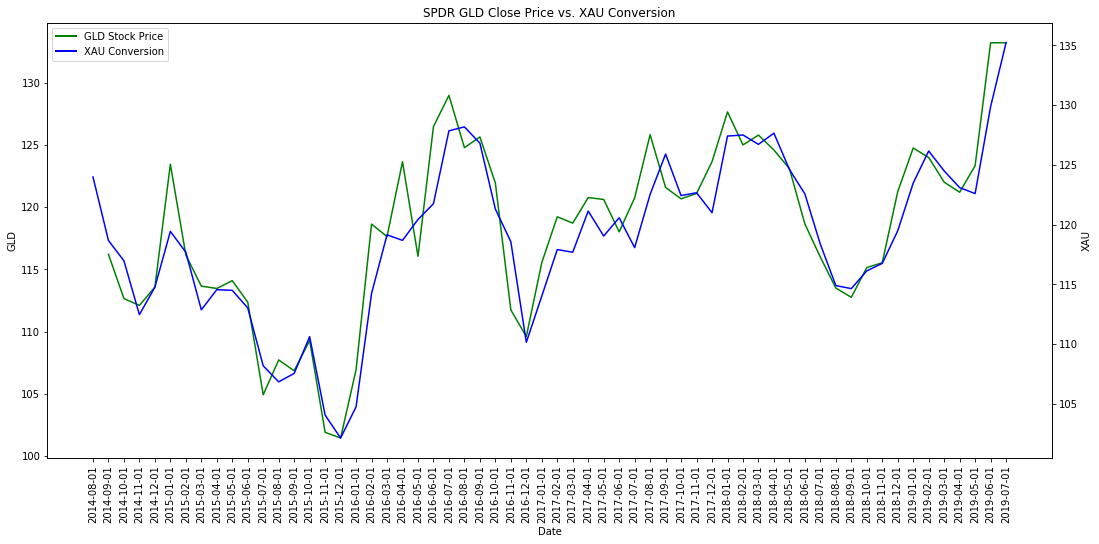

In [22]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='g', lw=2),
                Line2D([0], [0], color='b', lw=2)]

# Plot Close Price (G) vs. Cost of Physical Gold XAU (B)
fig, ax1 = plt.subplots(figsize=(18,8))
plt.title("SPDR GLD Close Price vs. XAU Conversion")
plt.xticks(rotation='vertical')
plt.legend(custom_lines, ['GLD Stock Price', 'XAU Conversion'])

x = dfObj['Date']
y1 = dfObj['Close']
y2 = dfObj['XAU_Conv']

ax2 = ax1.twinx()

ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel("Date")
ax1.set_ylabel("GLD")
ax2.set_ylabel("XAU")

Text(0, 0.5, '% Change in Gold Price')

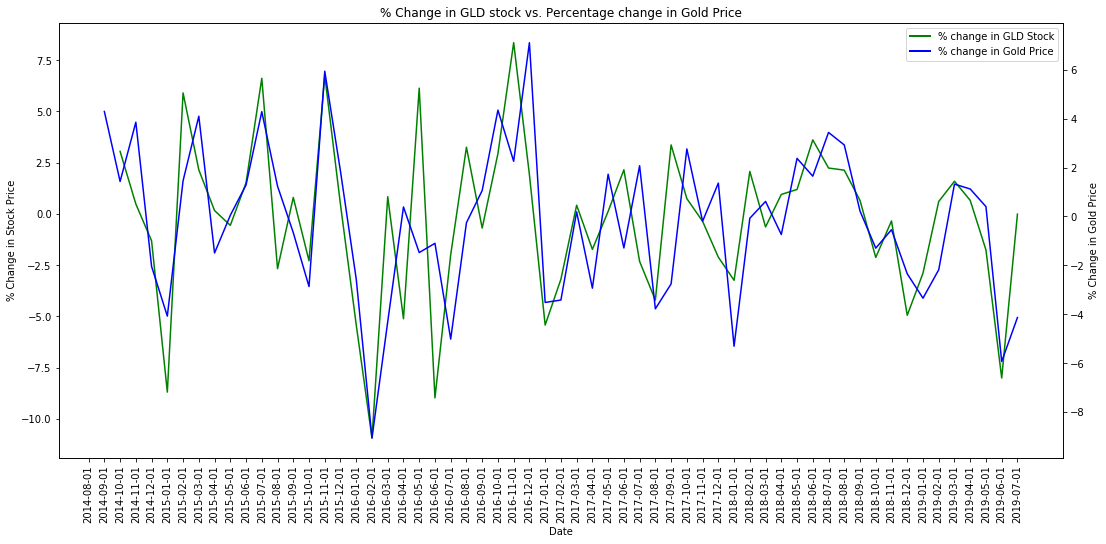

In [23]:
#Plot Close Price PctChng  (G) vs. Cost of Physical Gold PctChng (B)
fig, ax1 = plt.subplots(figsize=(18,8))
plt.title("% Change in GLD stock vs. Percentage change in Gold Price")
plt.xticks(rotation='vertical')
plt.legend(custom_lines, ['% change in GLD Stock', '% change in Gold Price'])

x = dfObj['Date']
y1 = dfObj['Close_Change']
y2 = dfObj['XAU_Change']

ax2 = ax1.twinx()

ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel("Date")
ax1.set_ylabel("% Change in Stock Price")
ax2.set_ylabel("% Change in Gold Price")

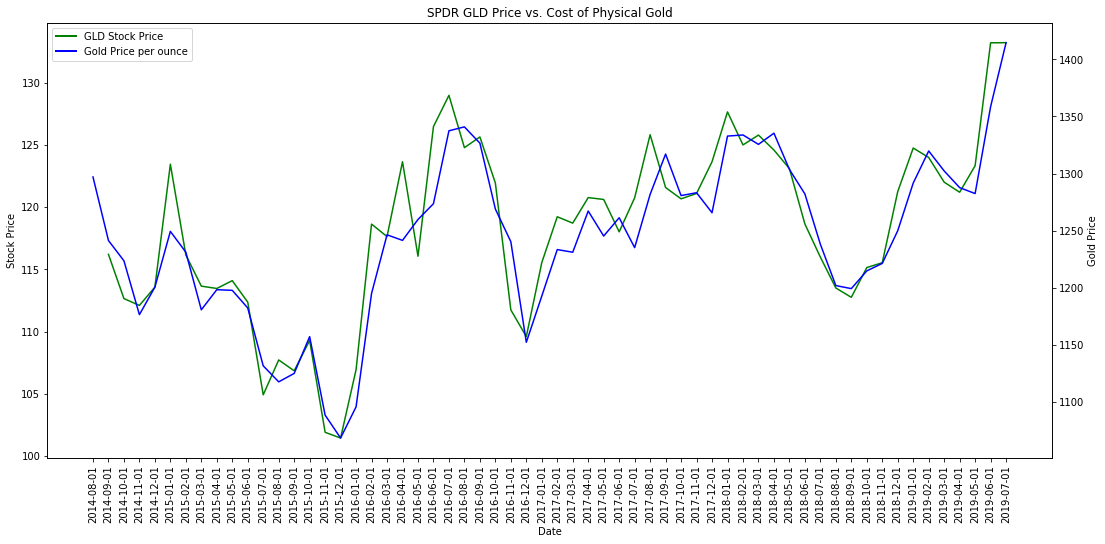

In [24]:
#Plot GLD stock close Price (G) vs. Cost of Physical Gold (B)
fig, ax1 = plt.subplots(figsize=(18,8))

plt.title("SPDR GLD Price vs. Cost of Physical Gold")
plt.xticks(rotation='vertical')
plt.legend(custom_lines, ['GLD Stock Price', 'Gold Price per ounce'])

x = merged_df['Date']
y1 = merged_df['Close']
y2 = merged_df['Price']

ax2 = ax1.twinx()

ax1.plot(x, y1, 'g')
ax2.plot(x, y2, 'b')
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price")
ax2.set_ylabel("Gold Price")

ax1.plot(color='g', label='GLD Stock Price')
ax2.plot(color='b', label='Gold Price per ounce')

plt.show()
